In [320]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import pmdarima as pm

from utils import display_metrics

import warnings
warnings.filterwarnings('ignore')

In [321]:
df = pd.read_csv('energy_antananarivo_cleaned.csv', index_col='date', parse_dates=True)

### 1.1 Information supplémentaire sur le données

In [322]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 516 entries, 1980-01-01 to 2023-12-01
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tot_nb_dmd  516 non-null    int64  
 1   tot_energy  516 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 12.1 KB


On voit que la variable 'date' est de type object(texte). Il faut la convertir en type Datetime pour pouvoir continuer à travailler 

In [323]:
# Vérification des valeurs manquantes
df.isnull().sum()

tot_nb_dmd    0
tot_energy    0
dtype: int64

## 2. Identification du modèle

### 2.1 Traçage du graphique de données

In [324]:
current_feature = 'tot_nb_dmd'
drop_feature = ''
if 'tot_nb_dmd' != current_feature:
    drop_feature = 'tot_nb_dmd'
else:
    drop_feature = 'tot_energy'

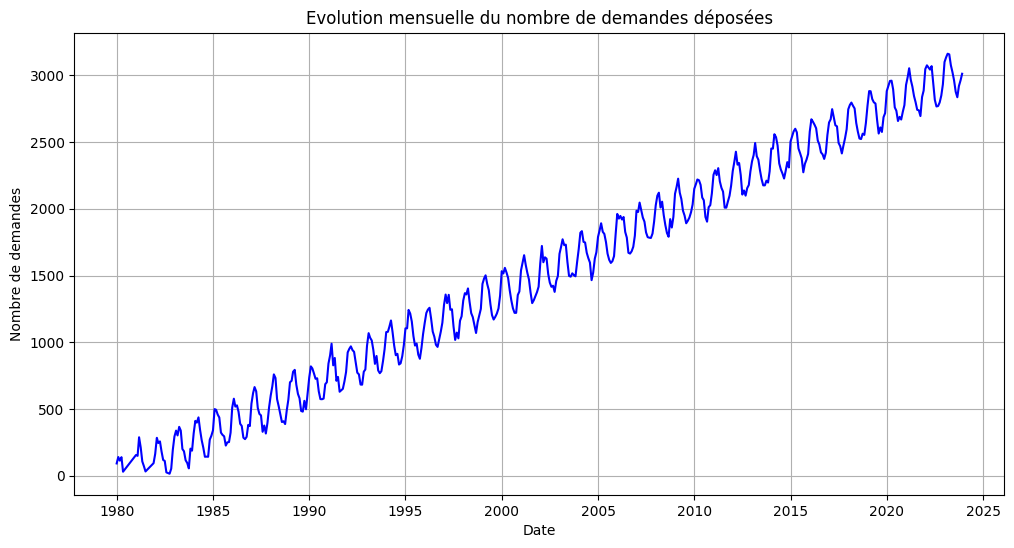

In [325]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df[current_feature], color='blue')
plt.title('Evolution mensuelle du nombre de demandes déposées')
plt.xlabel('Date')
plt.ylabel('Nombre de demandes')
plt.grid(True)
plt.show()

D'après le grapĥique, la série temporelle n'est pas stationnaire car:

- On constate une tendance qui augmente au fil du temps
- La moyenne n'est pas constante

Autres moyens de savoir si la série est stationnaire ou pas c'est d'utiliser les ACF et PACF.  
Les graphiques ACF et PACF sont couramment utilisés pour aider à choisir les paramètres d'un modèle ARIMA en analyse de series temporelles.

Par exemple: le graphique ACF est utilisé pour identifier le terme MA(moyenne mobile) du modèle. Tandisque le graphique de PACF peut être utilisé pour identifier le terme AR(auto-regressif).

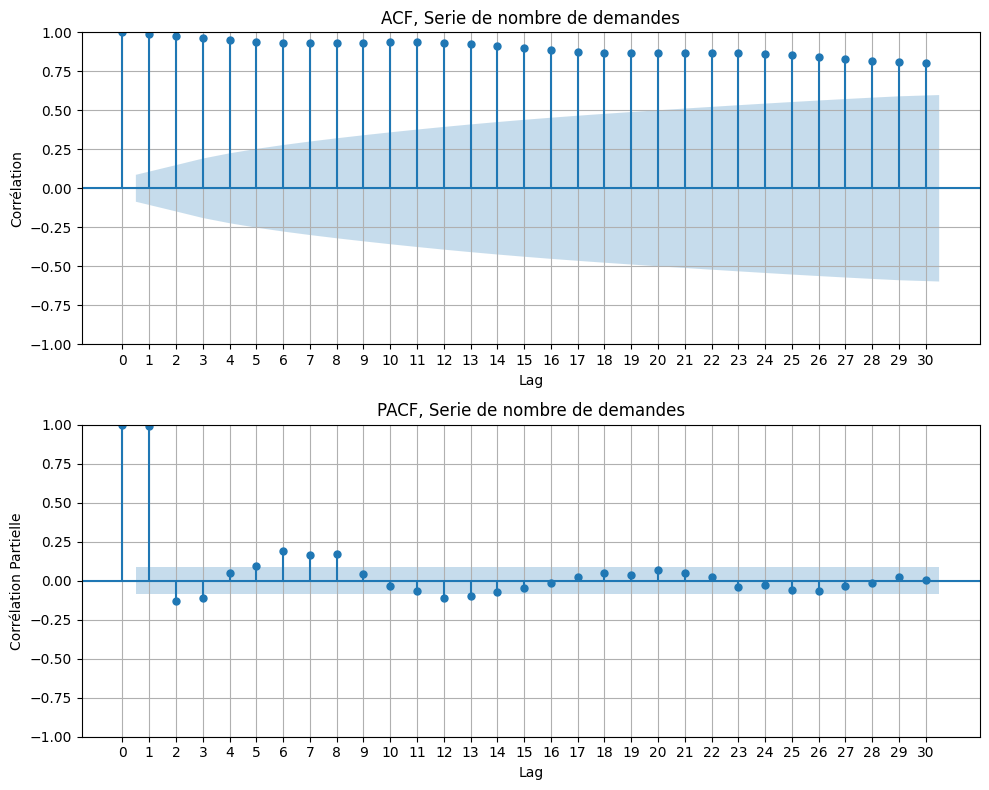

In [326]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Création des subplots 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))

# Traçage l'ACF
plot_acf(df[current_feature], lags=30, zero=True, ax=ax1)
ax1.set_title('ACF, Serie de nombre de demandes')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajustement des graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0,31,1))

# Traçage PACF
plot_pacf(df[current_feature], lags=30, zero=True, ax=ax2)
ax2.set_title('PACF, Serie de nombre de demandes')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation Partielle')
ax2.grid(True)

# Ajustement les graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0,31,1))

# Ajustement les subplots
plt.tight_layout()

plt.show()

**A propos de l'ACF**: le graphe montre qu'il y a une **decroissance regulière très lente pour la série**. Ce qui signifie déjà que la série est **non stationnaire**.

### 2.2 Analyse de la stationnarité de la variable

In [327]:

from tabulate import tabulate

# Test de Dickey-Fuller augmenté
result = adfuller(df[current_feature])

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La serie est non stationnaire']
]

print(tabulate(table, headers=['Metrique', 'Valeur'], tablefmt='github'))

| Metrique       | Valeur                        |
|----------------|-------------------------------|
| Valeur de test | 1.127765608225235             |
| P-valeur       | 0.9954467614572785            |
| Conclusion     | La serie est non stationnaire |


**p-valeur(0.95) est supérieur à 0.05**, donc on rejette l'hypothèse nulle. Donc la série est **non stationnaire**.

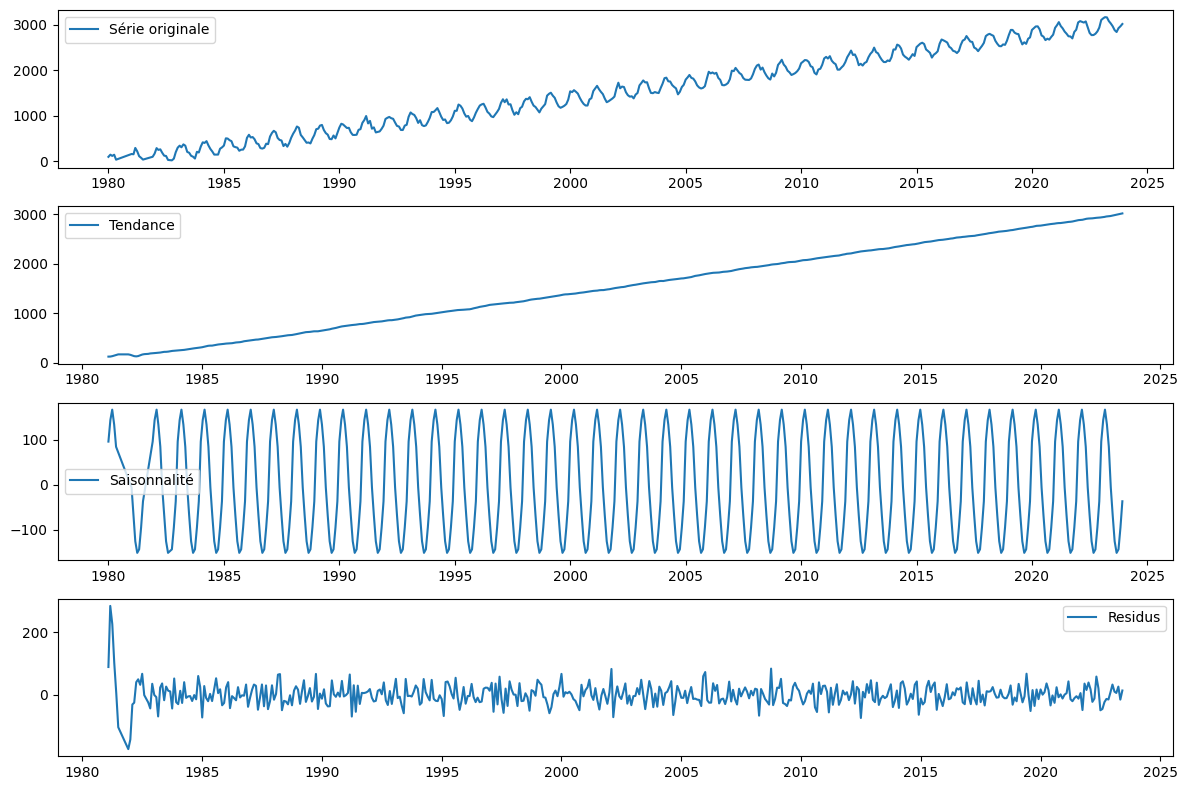

In [328]:
# Decompostion saisonnière
decomposition = seasonal_decompose(df[current_feature], model='additive', period=12)

# Extraction des composantes de la decomposotion
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Affichage des composantes de la décomposition
plt.figure(figsize=(12,8))

plt.subplot(411)
plt.plot(df[current_feature], label='Série originale')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendance')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Saisonnalité')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residus')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

Etant donnée que la serie est non stationnaire, on doit faire la différenciation pour la rendre stationnaire.

### 2.3 Différenciation(Stationnarisation) de la série

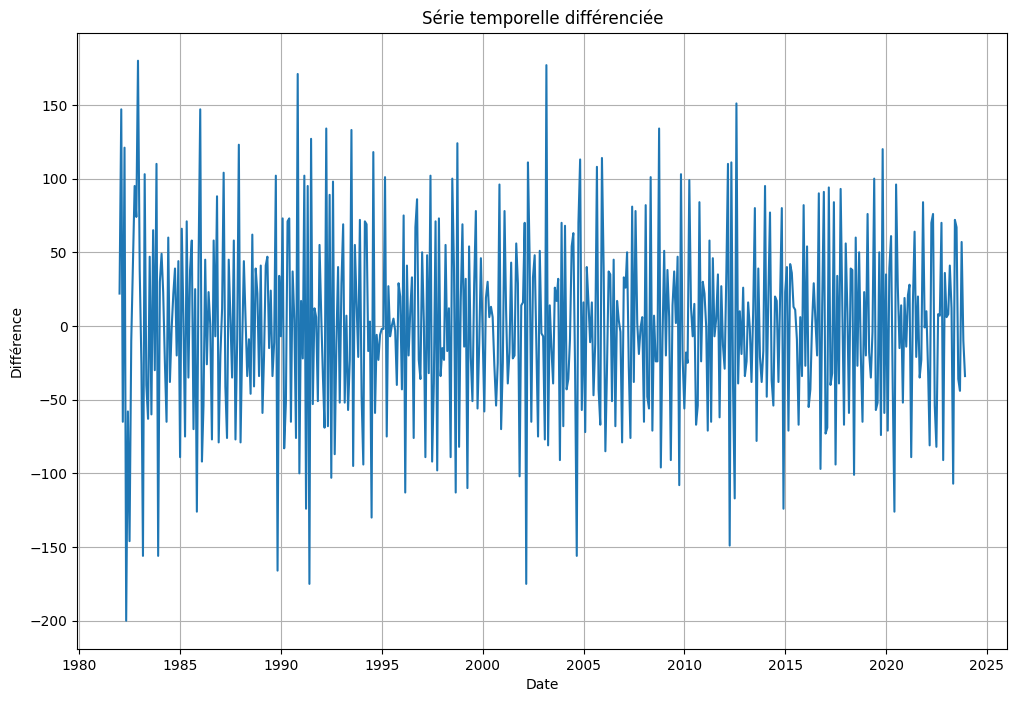

In [329]:
differenced = df[current_feature].diff().dropna()

# Differenciation saisonnière 
differenced = differenced.diff(12).dropna()

# Afficher la série différenciée
plt.figure(figsize=(12,8))
plt.plot(differenced)
plt.title('Série temporelle différenciée')
plt.xlabel('Date')
plt.ylabel('Différence')
plt.grid(True)
plt.show()

Malgré l'existence des variances un peu élevées, c'est beaucoup plus stationnaire que la série original.

### Retraçage de l'ACF et PACF avec la serie différenciée

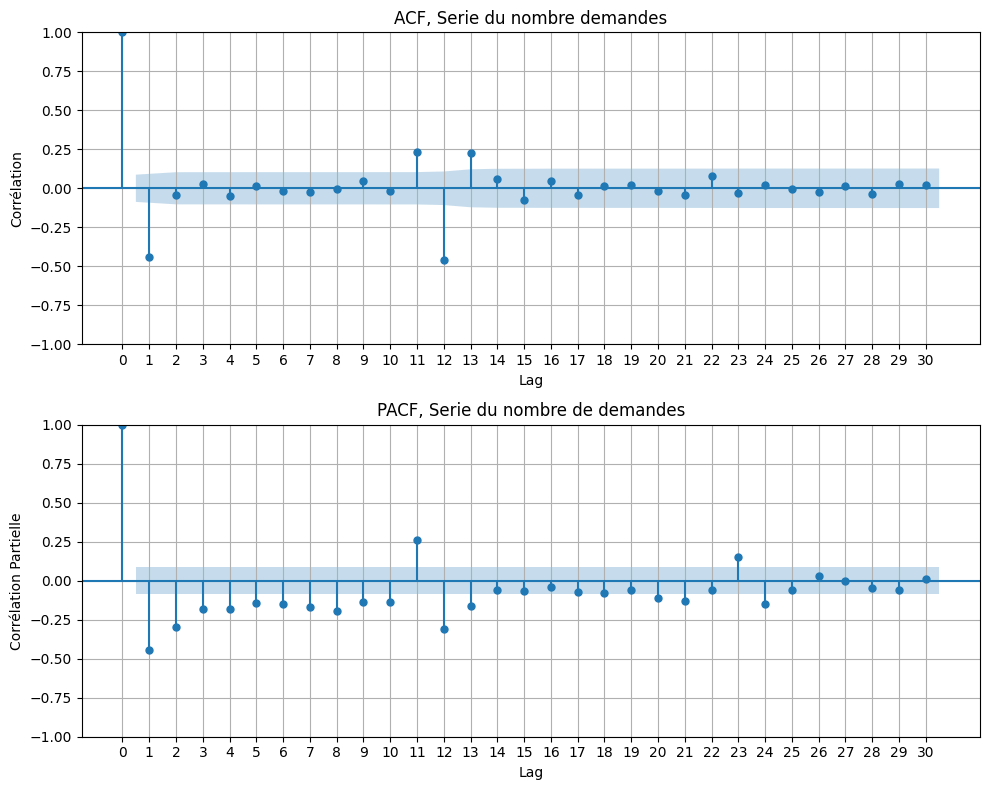

In [330]:
# Création des subplots 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))

# Traçage de l'ACF
plot_acf(differenced, lags=30, zero=True, ax=ax1)
ax1.set_title('ACF, Serie du nombre demandes')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajustement des graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0,31,1))

# Traçage du PACF
plot_pacf(differenced, lags=30, zero=True, ax=ax2)
ax2.set_title('PACF, Serie du nombre de demandes')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation Partielle')
ax2.grid(True)

# Ajustement des graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0,31,1))

# Ajustement des subplots
plt.tight_layout()

plt.show()

Concernant le graphe de l'ACF, le graphe montre l'absence de la décroissance lente. On peut dire que la série est maintenant stationnaire

In [331]:


train = df[current_feature][:-15]
# Utilisation de l'auto_arima pour trouver le meilleur modèle ARIMA
model =  pm.auto_arima(train)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  501
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -2743.565
Date:                Thu, 28 Mar 2024   AIC                           5501.131
Time:                        15:21:47   BIC                           5530.633
Sample:                             0   HQIC                          5512.708
                                - 501                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.9620      2.723      2.557      0.011       1.625      12.299
ar.L1          0.0776      0.041      1.884      0.060      -0.003       0.158
ar.L2          0.3096      0.040      7.761      0.0

### Analyse de la stationnarité de la variable avec la serie différenciée

In [332]:
# Test de Dickey-Fuller augmenté
result = adfuller(differenced)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La serie est non stationnaire']
]

print(tabulate(table, headers=['Metrique', 'Valeur'], tablefmt='github'))

| Metrique       | Valeur                    |
|----------------|---------------------------|
| Valeur de test | -9.637020299934177        |
| P-valeur       | 1.556728368193142e-16     |
| Conclusion     | La série est stationnaire |


### Identification de l'ordre de p,d,q
Pour identifier les p,q on revient dans les graphes:

- p est determiné à partir du graphe PACF:
- q est determiné à partir du graphe ACF:

In [333]:
p=2
d=1
q=1

## 3. Estimation du modèle

In [334]:
from statsmodels.tsa.arima.model import ARIMA

### 3.1 Création d'un modèle ARIMA

In [335]:
model = ARIMA(differenced, order=(2,1,1))

# Ajustement du modèle
model_fit = model.fit()

# Affichage du résumé du modèle
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             tot_nb_dmd   No. Observations:                  503
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2720.219
Date:                Thu, 28 Mar 2024   AIC                           5448.439
Time:                        15:21:47   BIC                           5465.313
Sample:                             0   HQIC                          5455.059
                                - 503                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5773      0.039    -14.928      0.000      -0.653      -0.501
ar.L2         -0.3025      0.036     -8.306      0.000      -0.374      -0.231
ma.L1         -0.9996      0.618     -1.617      0.106      -2.211       0.212
sigma2      2934.3885   1828.592      1.605      0.109    -649.587    6518.364
===================================================================================
Ljung-Box (L1) (Q):                   1.22   Jarque-Bera (JB):                61.76
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 7. Vérification du modèle

<Figure size 1200x800 with 0 Axes>

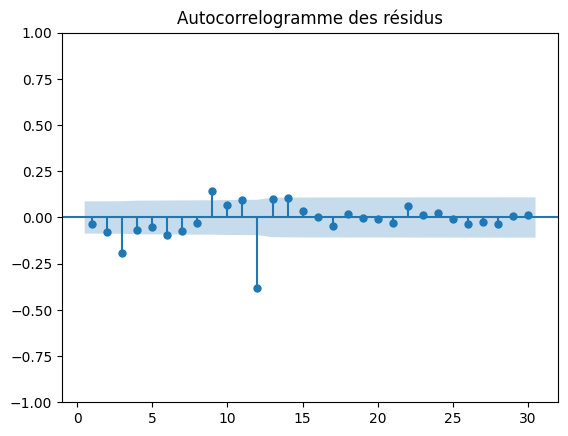

<Figure size 1200x800 with 0 Axes>

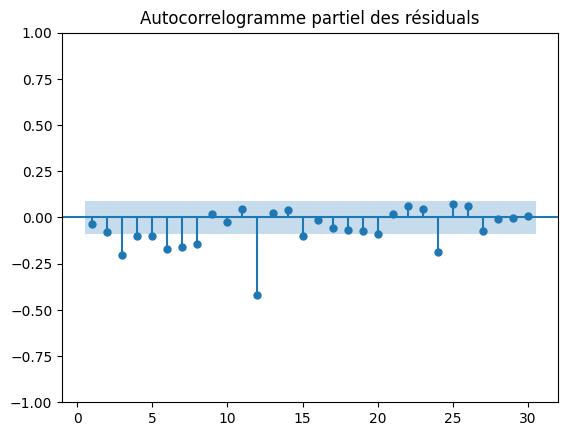

In [336]:
# calculer les résidus
residuals = model_fit.resid

# Tracer l'ACF des résidus
plt.figure(figsize=(12,8))
plot_acf(residuals, lags=30, zero=False)
plt.title('Autocorrelogramme des résidus')
plt.show()

# Tracer la PACF des résidus
plt.figure(figsize=(12,8))
plot_pacf(residuals, lags=30, zero=False)
plt.title('Autocorrelogramme partiel des résiduals')
plt.show()

Il y a quelques pics significatives dans PACF et ACF, mais globalement, on peut dire que les résidus sont des bruits blanc parceque on est, plus ou moins dans les bons résidus. Il faut se rappeler que les bruits sont des bruits blanc s'ils se trouvent à l'intérieur des zone bleues du graphique.

## 8. Prédiction

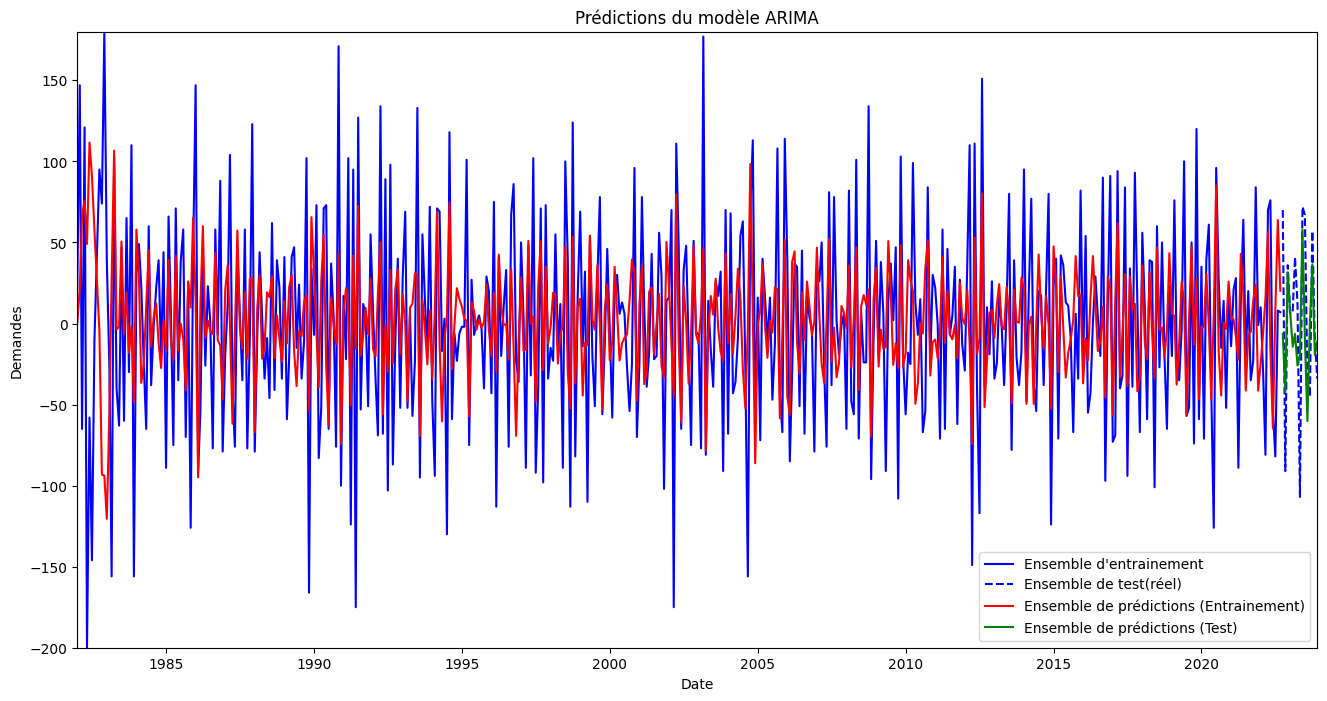

In [337]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Repartition des sets
train = differenced[:-15]
test = differenced[-15:]

# Prédiction sur l'ensemble d'entrainement
train_prediction = model_fit.predict(start=train.index[0], end=train.index[-1])

# Prédiction sur l'ensemble de test
test_prediction = model_fit.predict(start=test.index[0], end=test.index[-1])

# Traçage des predictions et les données réels avec les courbes collées.
plt.figure(figsize=(16,8))
plt.plot(train.index, train.values, label='Ensemble d\'entrainement', color='blue')
plt.plot(test.index, test.values, label='Ensemble de test(réel)', linestyle='--', color='blue')
plt.plot(train_prediction.index, train_prediction.values, label='Ensemble de prédictions (Entrainement)', color='red')
plt.plot(test_prediction.index, test_prediction.values, label='Ensemble de prédictions (Test)', color='green')

# Définition des limites des axes x et y pour une continuté visuelle.
plt.xlim(train.index[0], test.index[-1])
plt.ylim(min(train.min(), test.min()), max(train.max(), test.max()))

plt.xlabel('Date')
plt.ylabel('Demandes')
plt.title('Prédictions du modèle ARIMA')
plt.legend()
plt.show()

D'après le graphe:

- La prédiction de l'ensemble d'entrainement est bonne; elle(rouge) suit la courbe bleu
- Mais la prédiction de l'ensemble de test(vert) n'est pas bonne

In [338]:
perf = display_metrics(train, train_prediction, test, test_prediction)
perf

,Métriques:,Ensemble d'entrainenemt:,Ensemble de test:
0,MAE,42.165019,35.837063
1,MSE,3125.866538,1983.117083
2,RMSE,55.909449,44.532203
3,R²,0.226897,0.340627


On constate, d'après les mesures de métriques, que le modèle n'est pas bon

## 9. Processus de selection de modèle automatique

In [339]:
# Utilisation de l'auto_arima pour trouver le meilleur modèle ARIMA et
# Ré-entrainement avec l'ensemble de toutes les données

model =  pm.auto_arima(df[current_feature], seasonal=True, m=12)

print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  516
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood               -2728.316
Date:                             Thu, 28 Mar 2024   AIC                           5464.632
Time:                                     15:24:04   BIC                           5481.609
Sample:                                          0   HQIC                          5471.286
                                             - 516                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1340      0.034      3.919      0.000       0.067       0.201
ma.L1         -0.9433      

In [340]:
# model_fitted = model.fit(df[current_feature])
df

,tot_nb_dmd,tot_energy
date,,
1980-01-01,93,0.000346
1980-02-01,141,0.000525
1980-03-01,114,0.000425
1980-04-01,140,0.000522
1980-05-01,31,0.000115
...,...,...
2023-08-01,2877,0.022536
2023-09-01,2836,0.022215
2023-10-01,2920,0.022873


In [341]:
current_feature

'tot_nb_dmd'

In [342]:
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX

target_date = '2024-03-28'
df = df.drop(drop_feature, axis=1)
df.reset_index(drop=True)

#SARIMAX(1, 1, 1)x(1, 0, [], 12)
model = SARIMAX(df, order=(1, 1, 1), seasonal_order=(2, 0, [], 12), enforce_stationarity=False, trend='c', enforce_invertibility=False)
model_fit = model.fit()

target_datetime = datetime.strptime(target_date,'%Y-%m-%d')
fitted_values = model_fit.predict()
last_index = fitted_values.index[-1]
steps = int((target_datetime - last_index).days / 30)

# Utiliser le modèle pour faire des prédictions
forecast = model_fit.forecast(steps=steps)

forecast.iloc[-1]


# model_sarima = SARIMAX(df, order=(1, 1, 0), seasonal_order=(2, 0, [1, 2], 12), enforce_stationarity=False, trend='c', enforce_invertibility=False)
# optimized_model = model_sarima.fit()
# predictions = optimized_model.forecast(15)
# predictions

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.26541D+00    |proj g|=  3.47214D-01


 This problem is unconstrained.



At iterate    5    f=  5.09967D+00    |proj g|=  4.07287D-02

At iterate   10    f=  5.09206D+00    |proj g|=  2.09955D-02

At iterate   15    f=  5.01561D+00    |proj g|=  8.75512D-02

At iterate   20    f=  5.00691D+00    |proj g|=  8.49372D-03

At iterate   25    f=  4.91198D+00    |proj g|=  3.35087D-01

At iterate   30    f=  4.83048D+00    |proj g|=  3.55087D-01

At iterate   35    f=  4.82113D+00    |proj g|=  3.93704D-02

At iterate   40    f=  4.82040D+00    |proj g|=  5.76590D-03

At iterate   45    f=  4.82039D+00    |proj g|=  3.11766D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     84   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


3216.756286759777

In [343]:
import pickle

# Enregistrement de la fonction dans un fichier pickle
with open(f'model_{current_feature}_sarimax_fit.pkl', 'wb') as pkl_file:
    pickle.dump(model_fit, pkl_file)